In [1]:
import torch
import sklearn
import pandas as pd
import numpy as np

In [2]:
torch.__version__

'2.9.1+cu126'

In [3]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise = 0.03, random_state=42)


In [4]:
print(f"Firse 5 X features: \n {X[:5]}")
print(f"Firse 5 y labels: \n {y[:5]}")

Firse 5 X features: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Firse 5 y labels: 
 [1 1 1 1 0]


In [5]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y} )
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

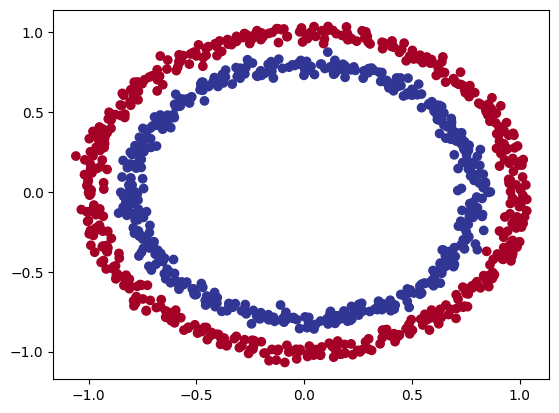

In [7]:
import matplotlib.pyplot as plt

plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
class CircleModelV0(nn.Module):
    def  __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Same thing but with nn.Sequential

In [14]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [15]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
untrained_preds = model_0(X_test.to(device))
print(f"First 1- predictions-{untrained_preds[:10]}")
print(f"First 10 test labels-{y_test[:10]}")

First 1- predictions-tensor([[-0.3991],
        [-0.3849],
        [-0.3517],
        [-0.4129],
        [-0.2175],
        [-0.2098],
        [-0.2763],
        [-0.2350],
        [-0.3574],
        [-0.3825]], device='cuda:0', grad_fn=<SliceBackward0>)
First 10 test labels-tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Create a loss function and an optimizer (an optimizer adjusts our model's parameters during training to minimize loss.)

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [18]:
def accuracy_fn(y_true, y_pred):
    # item() returns the element of that tensor.
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100
    

In [19]:
tensor = torch.tensor([0,9,2])
tensor.sum().item()

11

In [20]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3991],
        [-0.3849],
        [-0.3517],
        [-0.4129],
        [-0.2175]], device='cuda:0', grad_fn=<SliceBackward0>)

Logits are unnormalized outputs of your model. Suppose, a model outputs [16.07, 2.19] for a image of cat and dog, the values show that the model is confident that it is a cat. Now, it outputs [0.79, 0.56], again cat. But how do we compare both of the outputs? Why did the values decrease? Why was the model more confident at first? 

For this we convert logits into using function such as softmax or sigmoid in which the values add up to 1 and help us to think in probability distributions.

In [21]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4015],
        [0.4049],
        [0.4130],
        [0.3982],
        [0.4459]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [22]:
y_pred_labels = torch.round(model_0(X_test.to(device)))[:5]

y_pred_labels.squeeze()

tensor([-0., -0., -0., -0., -0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()
    
    # loss backwards
    loss.backward()

    #optimizer step
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test.to(device)).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}% ")



Epoch: 0 | Loss: 0.70611, Accuracy: 50.00% | Test Loss: 0.70424, Test Accuracy: 50.00% 
Epoch: 10 | Loss: 0.69805, Accuracy: 50.00% | Test Loss: 0.69653, Test Accuracy: 50.00% 
Epoch: 20 | Loss: 0.69541, Accuracy: 43.38% | Test Loss: 0.69392, Test Accuracy: 44.50% 
Epoch: 30 | Loss: 0.69448, Accuracy: 47.12% | Test Loss: 0.69302, Test Accuracy: 46.50% 
Epoch: 40 | Loss: 0.69409, Accuracy: 47.88% | Test Loss: 0.69270, Test Accuracy: 49.50% 
Epoch: 50 | Loss: 0.69389, Accuracy: 48.12% | Test Loss: 0.69259, Test Accuracy: 51.00% 
Epoch: 60 | Loss: 0.69376, Accuracy: 48.88% | Test Loss: 0.69257, Test Accuracy: 50.50% 
Epoch: 70 | Loss: 0.69365, Accuracy: 49.00% | Test Loss: 0.69259, Test Accuracy: 50.00% 
Epoch: 80 | Loss: 0.69357, Accuracy: 49.25% | Test Loss: 0.69263, Test Accuracy: 50.00% 
Epoch: 90 | Loss: 0.69350, Accuracy: 49.12% | Test Loss: 0.69268, Test Accuracy: 50.00% 


In [24]:
x = np.linspace(0,1,3)
y = np.linspace(1,2,3)
X, Y = np.meshgrid(x,y)
X, Y

(array([[0. , 0.5, 1. ],
        [0. , 0.5, 1. ],
        [0. , 0.5, 1. ]]),
 array([[1. , 1. , 1. ],
        [1.5, 1.5, 1.5],
        [2. , 2. , 2. ]]))

In [25]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.tensor, y:torch.tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))
    
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap = plt.cm.RdYlBu, alpha = 0.7)
    plt.scatter(X[:,0], X[:, 1], c = y, s = 40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

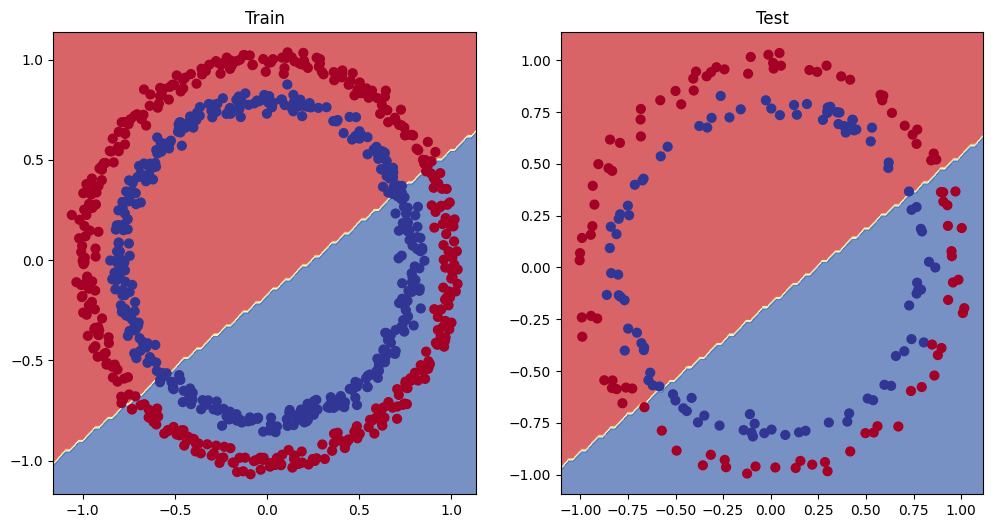

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(122)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
